In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from google.colab import files
from bs4 import BeautifulSoup
import requests
import re
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#files.upload()
data = pd.read_csv('gratkapl-centrenrm.csv')

In [ ]:
def get_page(url): # przygotowanie zupki przy użyciu biblioteki BeautifulSoup. Zupka to obiekt, na który składa się cała wartość pobieranej strony internetowej (tę pobiera się zaś przy użyciu biblioteki request)

    r = requests.get(url) # pobieranie zawartości strony - https://requests.readthedocs.io/en/master/

    if not r.ok: # weryfikacja, czy strona odpowiada - odpowiedź "200" to odpowiedź pozytywna - w tym 'ifie' wyświetlamy kod błędu, jeśli taki wystąpił
        print('Server responded: ', r.status_code)
    else:
        print('Server responded correctly: ', r.status_code)
        encoding = r.encoding if 'charset' in r.headers.get('content-type', '').lower() else None # namęczyłem się z tym strasznie - mała uwaga - BeautifulSoup ropzoznaje kodowanie strony automatycznej, niestety nie zawsze
        soup = BeautifulSoup(r.content, from_encoding=encoding)                                   # mu się udaje. Stworzenie zmiennej "encoding", przeszukuje "siłowo" zawartość strony w poszukiwaniu kodowania.
    return soup    # stworzenie i zwrócenie (hehe) gotowej zupki                                  # Dla języka polskiego to np windows-1250 albo utf-8 (w tym przypadku utf-8). Bez dekodowania polskie znaki byłyby krzaczkami

def extractor(soup): # funkcja, która pozwala wyciągnąć wszystko, czego oczekujemy ze strony - https://www.crummy.com/software/BeautifulSoup/bs4/doc/ (przeglądarka u mnie wskazuje stronę jako niebezpieczną,
                                                                                                  # ale to oficjalna strona biblioteki BeautifulSoup)

    streets = [i.text for i in soup.find_all('div') if str(i).count('col-sm-6') >= 1] # stworzenie listy, która będzie zawierała wszystkie ulice w Poznaniu, wraz z dzielnicami, w których się znajdują. Na tym etapie to jeden
    streets.remove(streets[0]) # pierwszy element listy odnosi się do navbaru         # string, podzielimy to wszystko później. W tym miejscu - soup.find_all('div') - wywołujemy metodę na obiekcie zupki. 
    return streets             # dlatego go wywaliłem                                 # Find_all wyszukuje wszystkie elementy typu <div>. <div> to element struktury strony w HTML, oznacza podział na sekcje.
                                                                                      
def street_district(streets):

    return {street.replace((''.join(re.findall(r'.*?\[(.*)].*',street))),'').replace('[]','').replace('ul.',''): # dict comprehension - co tu się właściwie dzieje? Działamy na liście stworzonej w funkcji extractor.
            (''.join(re.findall(r'.*?\[(.*)].*',street)))                                                        # Street to element listy - string, który wygląda przykładowo tak ul. Miśnieńska [Grunwald].
            for street in streets}                                                                               # Najpierw klucz (key) słownika - czyli nazwa naszej ulicy.
                                                                                                                 # street.replace ma na celu wyrzucanie zbędnych elementów stringa (.replace świetnie nadaje się do
                                                                                                                 # wywalania 'substringów). Wywalamy tutaj 'ul.', następnie '[]', a z pomocą biblioteki 're' - 
                                                                                                                 # która służy do wyszukiwania wyrażeń regularnych (regular expressions) szukamy tego, co jest pomiędzy
                                                                                                                 # kwadratowymi nawiasami. https://docs.python.org/3/library/re.html - .*?\[(.*)].* <- to jest określona
                                                                                                                 # ekspresja, której funkcja findall ma szukać w stringu. Oznacza tyle, co "znajdź to, co jest między []".
                                                                                                                 # To również wywalamy z naszej nazwy ulicy - bo ma iść do wartości, a nie do klucza w słowniku.
                                                                                                                 # Ten sam regex (regular expression) zastosowany jest do wygenerowania wartości (czyli dzielnicy) 
                                                                                                                 

soup.find_all('div') - Skąd wiemy, że akurat ten element należy wpisać w soup.find_all? Wynika to ze struktury HTML, na podstawie której została postawiona strona. Niestety - nie da się zautomatyzować tego procesu. Każda strona, nazewnictwo klas poszczególnych elementów, umiejscowienie tego, co nas interesuje, różnią się od siebie. Na jakiejkolwiek stronie kliknijcie prawym przyciskiem myszy, a nastepnie "Zbadaj element" (dla Opery). To właśnie z tego tworzymy zupkę przy pomocy request i BeautifulSoup. Dalej, po soup.find_all('div') mamy instrukcję warunkową - if str(i).count('col-sm-6') >= 1 . Oznacza ona tyle, że jeśli w stringu danego diva, którego znalazł find_all jest nazwa klasy 'col-sm-6' to jest właśnie to ,czego szukamy, a odrzucamy całą resztę. Nazwę klasy również znajdziemy w zupce, trzeba ją po prostu wyszukać. Spis ulic Poznania jest zrobiony na tyle dobrze, że wszystkie ulice znajdziemy pod 'div' tej samej klasym, więc dla wszystkich 2302 ulic, potrzebujemy tylko jednej linijki kodu. 


In [ ]:
url = 'http://mapa.livecity.pl/ulice/Poznań,0969400,1' # url do stronki z ulicami Poznania

street_dict = street_district(extractor(get_page(url))) # słyszałem, że lubicie funkcje, więc wsadziłem funkcję, w funkcję, która jest w funkcji
data_district = pd.DataFrame.from_dict(street_dict, orient='index', columns=['District']) # tworzymy dataframe 
data_hot_district = pd.get_dummies(data_district) # przekształcamy metodą one hot vector 
data_hot_district

Server responded correctly:  200


,District_Grunwald,District_Jeżyce,District_Nowe Miasto,District_Stare Miasto,District_Wilda
Miśnieńska,1,0,0,0,0
Słowicza,1,0,0,0,0
Niecała,1,0,0,0,0
Boczna,1,0,0,0,0
Budziszyńska,1,0,0,0,0
...,...,...,...,...,...
Bohaterów Westerplatte,0,0,0,0,1
Jodłowa,0,0,0,0,1
ks. Jakuba Wujka,0,0,0,0,1
Korzenna,0,0,0,0,1


In [ ]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data_filtered = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_filtered


,Id,Expected,Rooms,SqrMeters,Floor,Location,Centre,Description
1,437,280000,2,41.00,5,Poznań Poznań-Wilda,0,Polecam do sprzedaży mieszkanie dwupokojowe pr...
2,1139,329000,2,50.50,1,Poznań Ogrody,0,Polecam na sprzedaż mieszkanie 2-pokojowe na p...
4,192,280000,2,69.00,3,Poznań Wilda ul. Traugutta,0,Salon nieruchomości Iron House poleca na sprze...
6,277,239000,2,47.00,4,Poznań ul. Łokietka Osiedle,0,Polecam do sprzedaży 2-pokojowe mieszkanie poł...
7,1117,269000,2,45.00,4,Poznań Piątkowo Winogrady Sołacz Naramow ul. B...,1,BEZPIECZNA TRANSAKCJA JEDYNIE Z DOŚWIADCZONYM ...
...,...,...,...,...,...,...,...,...
2013,128,277000,2,46.10,3,Poznań Naramowice Piątkowo Winogrady ul. Sielawy,0,Kupując z pośrednikiem - kupujesz bezpiecznie ...
2014,484,371000,3,47.00,2,Poznań Łazarz ul. Grottgera 15/19,0,Najbardziej Prestiżowy Adres w Poznaniu!! Prze...
2015,795,341600,2,61.00,1,Poznań Poznań-Grunwald ul. Jana Matejki,0,Oferta sprzedaży mieszkania o łącznej powierzc...
2016,1562,149000,1,28.00,3,Poznań Dębiec,0,Kawalerka 28m2 na Dębcu SUPER CENA !!!! Poleca...


In [ ]:
#X = data_filtered[['Expected','Rooms', 'SqrMeters', 'Floor']]
#y = data_filtered['Centre']

In [ ]:
y.value_counts()

0    1324
1     258
Name: Centre, dtype: int64

In [ ]:
data_majority = data_filtered[data_filtered['Centre'] == 0]
data_minority = data_filtered[data_filtered['Centre'] == 1]

data_minority_unsampled = resample(data_minority, replace=True, n_samples=1324, random_state=42)
data_unsampled = pd.concat([data_majority, data_minority_unsampled])

data_majority_downsampled = resample(data_majority, replace=False, n_samples=258, random_state=42)
data_downsampled = pd.concat([data_minority, data_majority_downsampled])

scaler_unsampled = StandardScaler()
X_unsampled = scaler_unsampled.fit_transform(data_unsampled[['Expected','Rooms', 'SqrMeters', 'Floor']])
y_unsampled = data_unsampled['Centre']

scaler_downsampled = StandardScaler()
X_downsampled = scaler_downsampled.fit_transform(data_downsampled[['Expected','Rooms', 'SqrMeters', 'Floor']])
y_downsampled = data_downsampled['Centre']

              precision    recall  f1-score   support

           0       0.97      0.82      0.89       331
           1       0.84      0.98      0.90       331

    accuracy                           0.90       662
   macro avg       0.91      0.90      0.90       662
weighted avg       0.91      0.90      0.90       662



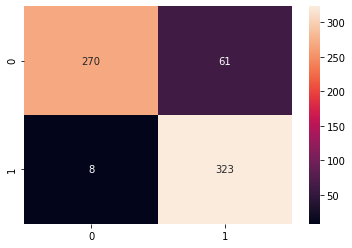

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_unsampled, y_unsampled, stratify = y_unsampled, random_state = 42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.66      0.67        65
           1       0.66      0.67      0.67        64

    accuracy                           0.67       129
   macro avg       0.67      0.67      0.67       129
weighted avg       0.67      0.67      0.67       129



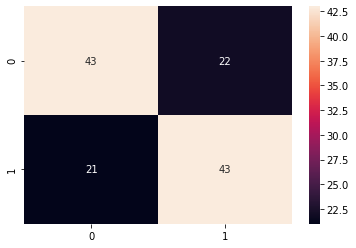

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, stratify = y_downsampled, random_state = 42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       331
           1       0.21      0.23      0.22        65

    accuracy                           0.73       396
   macro avg       0.53      0.53      0.53       396
weighted avg       0.74      0.73      0.74       396



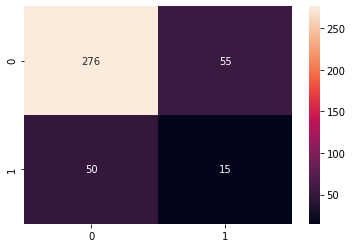

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_filtered[['Expected', 'Rooms', 'SqrMeters', 'Floor']],data_filtered['Centre'], stratify = data_filtered['Centre'], random_state = 42)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       331
           1       0.60      0.62      0.61       331

    accuracy                           0.60       662
   macro avg       0.60      0.60      0.60       662
weighted avg       0.60      0.60      0.60       662



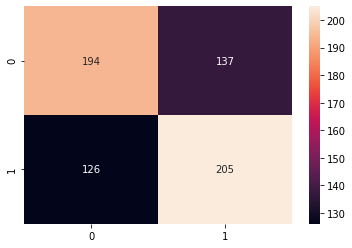

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_unsampled, y_unsampled, stratify = y_unsampled, random_state = 42)

model = AdaBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89       331
           1       0.84      0.98      0.91       331

    accuracy                           0.90       662
   macro avg       0.91      0.90      0.90       662
weighted avg       0.91      0.90      0.90       662



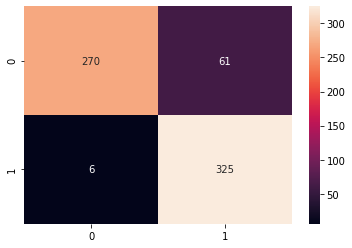

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_unsampled, y_unsampled, stratify = y_unsampled, random_state = 42)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, y_pred))